In [1]:
import os
import keras

import numpy as np
import cv2 # 載入 cv2 套件
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("The shape of x_train", x_train.shape)
print("The shape of y_train", y_train.shape)
print("The shape of x_test", x_test.shape)
print("The shape of y_test", y_test.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 16s 0us/step
The shape of x_train (50000, 32, 32, 3)
The shape of y_train (50000, 1)
The shape of x_test (10000, 32, 32, 3)
The shape of y_test (10000, 1)


In [0]:
# 產生直方圖特徵的訓練資料

x_train_histogram = []
x_test_histogram = []

# 對於所有訓練資料
for i in range(len(x_train)):
    chans = cv2.split(x_train[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())
    # 把計算的直方圖特徵收集起來
    x_train_histogram.append(hist_feature)

# 對於所有測試資料也做一樣的處理
for i in range(len(x_test)):
    chans = cv2.split(x_test[i]) # 把圖像的 3 個 channel 切分出來
    # 對於所有 channel
    hist_feature = []
    for chan in chans:
        # 計算該 channel 的直方圖
        hist = cv2.calcHist([chan], [0], None, [16], [0, 256]) # 切成 16 個 bin
        hist_feature.extend(hist.flatten())
    x_test_histogram.append(hist_feature)

x_train_histogram = np.array(x_train_histogram)
x_test_histogram = np.array(x_test_histogram)

In [0]:
# 產生HOG特徵的訓練資料
# HOG 特徵通過計算和統計圖像局部區域的梯度方向直方圖來構建特徵

# SZ=20
bin_n = 16 # Number of bins

def hog(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist.astype(np.float32)

x_train_hog = np.array([hog(x) for x in x_train])
x_test_hog = np.array([hog(x) for x in x_test])

In [0]:
# using SVM for training (Histogram)

SVM_hist = cv2.ml.SVM_create()
SVM_hist.setKernel(cv2.ml.SVM_LINEAR)
SVM_hist.setGamma(5.383)
SVM_hist.setType(cv2.ml.SVM_C_SVC)
SVM_hist.setC(2.67)

#training
SVM_hist.train(x_train_histogram, cv2.ml.ROW_SAMPLE, y_train)

# prediction
_, y_hist_train = SVM_hist.predict(x_train_histogram)
_, y_hist_test = SVM_hist.predict(x_test_histogram)

In [0]:
# using SVM for training again (HOG)

SVM_hog = cv2.ml.SVM_create()
SVM_hog.setKernel(cv2.ml.SVM_LINEAR)
SVM_hog.setGamma(5.383)
SVM_hog.setType(cv2.ml.SVM_C_SVC)
SVM_hog.setC(2.67)

#training
SVM_hog.train(x_train_hog, cv2.ml.ROW_SAMPLE, y_train)

# prediction
_, y_hog_train = SVM_hog.predict(x_train_hog)
_, y_hog_test = SVM_hog.predict(x_test_hog)

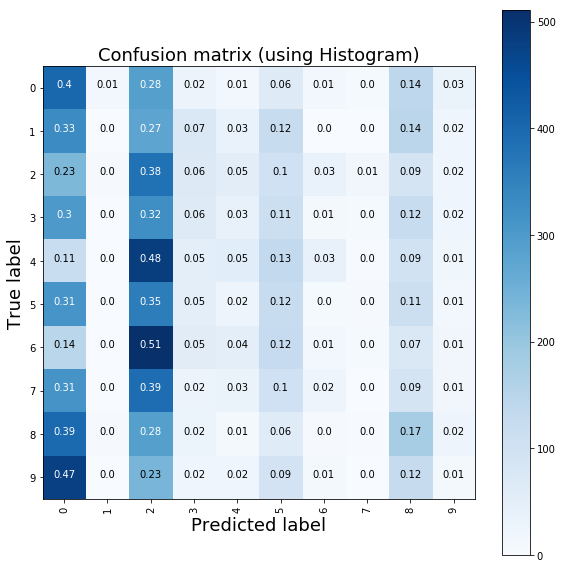

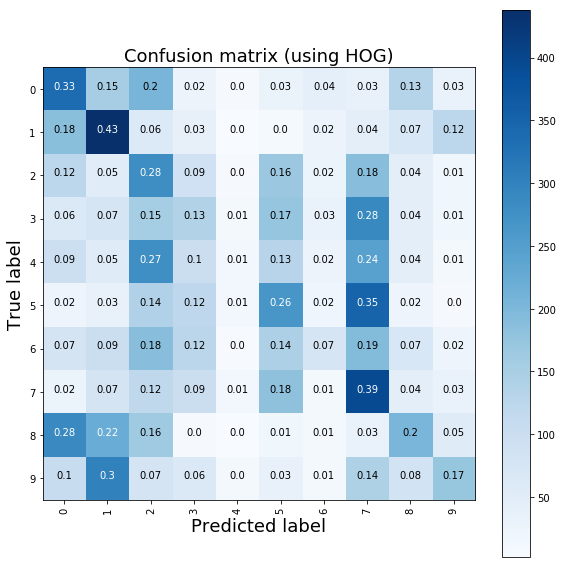

The accuracy using historgram features is %f % 12.28
The accuracy using hog features is %f % 19.89


In [6]:
# so in this task, we want to classify the data into 10 classes
# after training using SVM by histogram features and HOG features
# now we have to evaluate the accuracy and get the confusion matrices

from sklearn.metrics import confusion_matrix
import itertools
num_class = 10
classes = ['0','1','2','3','4','5','6','7','8','9']

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm=(cm*100+.01).astype(int)/100

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label',fontsize= 18)
    plt.xlabel('Predicted label',fontsize = 18)
    

confusion_mtx = confusion_matrix(y_test, y_hist_test) 
plot_confusion_matrix(confusion_mtx, classes =classes,title = "Confusion matrix (using Histogram)")
plt.show()

confusion_mtx = confusion_matrix(y_test, y_hog_test) 
plot_confusion_matrix(confusion_mtx, classes =classes,title = "Confusion matrix (using HOG)")
plt.show()

right_hist = 0
right_hog = 0
for i in range(len(y_test)):
  if y_test[i] == y_hist_test[i]:
    right_hist += 1
    
  elif y_test[i] == y_hog_test[i]:
    right_hog += 1
    
acc_hist = (right_hist/len(y_hist_test))*100
acc_hog = (right_hog/len(y_hog_test))*100

print("The accuracy using historgram features is %f %", np.round(acc_hist,3))
print("The accuracy using hog features is %f %", np.round(acc_hog,3))